# Agenda  <a name="backtotop"></a>
---

1. [General Trend](#GT)
2. [Fit By Logistic Regression](#LR)
3. [Fit By Multinomial Naive Bayes](#MNB)
4. [Fit By Random Forest](#RF)
5. [Fit By Gradient Boosting Machines ](#GBM)
6. [Fit By Naive Bayes SVM](#NBSVM)
7. [Fit By Multilayer Perceptron Neural Network(MLP)](#MLP)
8. [Fit By LSTM Neural Network](#LSTM)
9. [Fit By Bidirectional LSTM Neural Net]

## Libraries

In [1]:
%matplotlib inline
import re
import six
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_X_y, check_array
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.svm import LinearSVC 
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.sparse import issparse
from scipy import sparse

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm import tqdm
from abc import ABCMeta



## Raw Data

In [2]:
path = "data/"
DJIA_fn = "DJIA_table.csv"
News_fn = "Combined_News_DJIA.csv"

DJIA_df = pd.read_csv(path + DJIA_fn)
DJIA_df = DJIA_df.sort_values("Date")
DJIA_df.index = range(len(DJIA_df))

News_df = pd.read_csv(path + News_fn)
News_df = News_df.sort_values("Date")
News_df.index = range(len(News_df))

## General Trend <a name = "GT"></a>

[Back to Top](#backtotop)

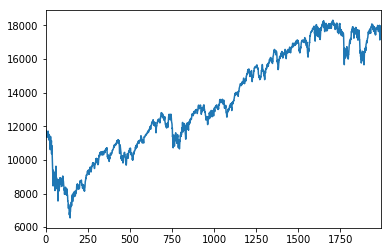

In [3]:
DJIA_df["Adj Close"].plot()
plt.show()

## Clean data in News_df

In [4]:
def RemoveQuote(tmp_str):
    s_quote = False
    d_quote = False
    start_list = []
    end_list = []
    mid_str = tmp_str[5:len(tmp_str)-5]
    for i in range(5):
        if (not s_quote) or (not d_quote):
            try:
                if tmp_str[i] != "\'" and tmp_str[i] != "\"":
                    if i <=2 and tmp_str[i] == 'b':
                        continue
                    start_list.append(tmp_str[i])
                if tmp_str[-5+i] != "'" and tmp_str[-5+i] != '"':
                    end_list.append(tmp_str[-5+i])
            except:
                print(tmp_str)

    tmp_str = "".join(start_list) + mid_str + "".join(end_list)
    return tmp_str

headline_columns = [x for x in News_df.columns if re.match("Top", x)]
for col in headline_columns:
    News_df[col] = News_df[col].apply(lambda x: RemoveQuote(x) if x == x else x)
Comb_df = DJIA_df.merge(News_df, on = "Date", how = "inner")

## Make Training Data and Testing Data (8:2)

In [5]:
train_index = pd.to_datetime(DJIA_df.Date, format = "%Y-%m-%d") < pd.to_datetime("2014-12-31", format = "%Y-%m-%d")
train_data = Comb_df[train_index]
test_data = Comb_df[~train_index]

## Joint Top Hottest Headlines and Tokenize and Vecterize Text into Metrix

In [6]:
joint_headlines_train = train_data[headline_columns[0]]
joint_headlines_test = test_data[headline_columns[0]]
for i in range(1, len(headline_columns)):
    joint_headlines_train += (' ' + train_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))
    joint_headlines_test += (' ' + test_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))

basicVetorizer = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))
basic_train = basicVetorizer.fit_transform([x for x in joint_headlines_train.values if x == x])
basic_test = basicVetorizer.transform([x for x in joint_headlines_test.values if x == x])
basic_whole = basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x==x])

# Fit by Logistic Regression <a name = "LR"></a>
    
[Back to Top](#backtotop)
> Find the best score by Grid Search on Penalty C <br>
> **Assumptions:** <br>
> - The outcome is binary <br>
> - The observations are independent to each other <br>
> - Absence of multicollinearity <br>
> - Linearity of independent variables and log odds <br>
> - Large size of database <br>


In [7]:

logistic_model = LogisticRegression(solver='lbfgs')
# logistic_model = logistic_model.fit(basic_train, train_data.Label)


gs = GridSearchCV(logistic_model, {'C': [0.001,0.01,0.1,1,10,100,1000]}, cv = 12, scoring='accuracy',)
gs.fit(TruncatedSVD(n_components=10).fit_transform(basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x == x])), Comb_df.Label.values)

print("Best Score = ", gs.best_score_)

Best Score =  0.5354449472096531


**Comment**:
> Logistic perform the best when C is around 0.001
> The length of tokens does not really change the accuracy (tried 1-3 grams)

## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)

In [8]:
from sklearn.decomposition import TruncatedSVD
accuracy_list = []

for num_compo in range(1, 632):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    logistic_model = logistic_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(logistic_model.predict(basic_test_svd), test_data.Label))

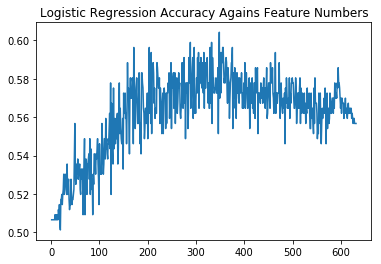

In [9]:
plt.plot(range(1, 632), accuracy_list)
plt.title("Logistic Regression Accuracy Agains Feature Numbers")
plt.show()

**Comment:**
> The graph shows the extraordinary features pottentially reduce the accruacy from 0.02-0.01 <br>
> The most ideal accruacy was made at around 480 number of features <br>

# Fit by Multinomial Naive Bayes <a name = "MNB"></a>

[Back to Top](#backtotop)

In [10]:
NB_model = MultinomialNB()
param = {"alpha": np.arange(0, 10, 0.2)}
gd_NB = GridSearchCV(NB_model, param, cv = 5)
gd_NB.fit(basic_whole, Comb_df.Label.values)
print("Best Score = %.2f with alpha = %.2f"%(gd_NB.best_score_, gd_NB.best_params_['alpha'] ))

/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Score = 0.55 with alpha = 7.40


## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)
**Notice**: <br>
By practice, this won't work since SVD created negative input for naive base, **which is not allowed**
<br>
```python 
SVD_model = TruncatedSVD(n_components=380)
basic_train_svd = SVD_model.fit_transform(basic_train)
basic_test_svd = SVD_model.transform(basic_test)

NB_model = MultinomialNB()
NB_model = NB_model.fit(basic_train_svd, train_data.Label.values)
accuracy_score(NB_model.predict(basic_test_svd), test_data.Label.values)
```

# Fit by Random Forest <a name = "RF"></a>

[Back to Top](#backtotop)

**Comment:**<br>
- Even it is not shown below, I tuned the model by **N_estimators, max_depth, min_samples_split, min_samples_leaf, max_features** respectively but the accuracy did not indicate any strong changes

In [11]:
accuracy_list = []
cv = 10
cv_list = []
for i in range(cv):
    RF_model = RandomForestClassifier(n_estimators= 32)
    RF_model = RF_model.fit(basic_train, train_data.Label.values)
    cv_list.append(accuracy_score(RF_model.predict(basic_test), test_data.Label.values))
new_accuracy = np.average(cv_list)
print("Average accuarcy = ", new_accuracy)

Average accuarcy =  0.520580474934037


### TruncatedSVD + Random Forest
**Comment:**
- The dimension reduction does not really improve the prediction

In [ ]:
accuracy_list = []
RF_model = RandomForestClassifier(n_estimators= 32)
rang = range(1, 632)
for num_compo in tqdm(rang):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    RF_model = RF_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(RF_model.predict(basic_test_svd), test_data.Label))

In [ ]:
plt.plot(rang, accuracy_list)
plt.show()

# Fit by Gradient Boosting Machines <a name = "GBM"></a>

[Back to Top](#backtotop)

**Comment**:<br>
The result is pretty much very similar to Random Forest

In [ ]:
accuracy_list = []
cv = 10
cv_list = []
for i in range(cv):
    GBM_model = GradientBoostingClassifier(n_estimators= 10, n_iter_no_change = 3)
    GBM_model = GBM_model.fit(basic_train, train_data.Label.values)
    cv_list.append(accuracy_score(GBM_model.predict(basic_test), test_data.Label.values))
new_accuracy = np.average(cv_list)
print("Average accuarcy = ", new_accuracy)

In [ ]:
accuracy_list = []
GBM_model = GradientBoostingClassifier(n_estimators= 32)
rang = range(1, 632)
for num_compo in tqdm(rang):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    GBM_model = GBM_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(GBM_model.predict(basic_test_svd), test_data.Label))

In [ ]:
plt.plot(rang, accuracy_list)
plt.show()

# Fit by Naive Bayes SVM <a name = "NBSVM"></a>

[Back to Top](#backtotop)

**Comment**:<br>
- Naive Base(NB) and Support Vector Machine(SVM) are widely used as base-line in test-related task. Their accuracy varies significantly across varients, features and datasets
- **NB does better job than SVM in short snippet sentiment tasks, while SVM outperforms NB in long documents**
- A SVM varients using NB log-count ratio as a feature constantly performs well

In [ ]:

class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


def main(train_file, test_file, ngram=(1, 3)):
    print('loading...')
    train = pd.read_csv(train_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    # to shuffle:
    #train.iloc[np.random.permutation(len(df))]

    test = pd.read_csv(test_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    print('vectorizing...')
    vect = CountVectorizer()
    classifier = NBSVM()

    # create pipeline
    clf = Pipeline([('vect', vect), ('nbsvm', classifier)])
    params = {
        'vect__token_pattern': r"\S+",
        'vect__ngram_range': ngram, 
        'vect__binary': True
    }
    clf.set_params(**params)

    #X_train = vect.fit_transform(train['text'])
    #X_test = vect.transform(test['text'])

    print('fitting...')
    clf.fit(train['text'], train['label'])

    print('classifying...')
    pred = clf.predict(test['text'])
   
    print('testing...')
    acc = accuracy_score(test['label'], pred)
    f1 = semeval_senti_f1(pred, test['label'])
    print('NBSVM: acc=%f, f1=%f' % (acc, f1))

# Fit by Multilayer Perceptron Neural Network(MLP) <a name = "MLP"></a>

[Back to Top](#backtotop)


In [56]:
accuracy_list = []
rang = np.arange(10, 5000, 100)
for num in tqdm(rang):
    MPLNN_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape = (basic_train.shape[1],)),
        tf.keras.layers.Dense(2800, activation="relu"),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(2, activation = "softmax")
    ])

    MPLNN_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
    MPLNN_model.fit(basic_train, train_data.Label.values)
    y_predict = MPLNN_model.predict_classes(basic_test)
    accuracy_list.append(accuracy_score(y_predict, test_data.Label.values))


  0%|          | 0/50 [00:00<?, ?it/s]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6942



  2%|▏         | 1/50 [00:04<03:32,  4.33s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6957



  4%|▍         | 2/50 [00:08<03:23,  4.25s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6998



  6%|▌         | 3/50 [00:12<03:20,  4.26s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6955



  8%|▊         | 4/50 [00:17<03:21,  4.38s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6975



 10%|█         | 5/50 [00:21<03:16,  4.38s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6984



 12%|█▏        | 6/50 [00:26<03:11,  4.36s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6965



 14%|█▍        | 7/50 [00:30<03:08,  4.39s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6950



 16%|█▌        | 8/50 [00:35<03:06,  4.43s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6948



 18%|█▊        | 9/50 [00:39<03:03,  4.48s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6948



 20%|██        | 10/50 [00:44<03:02,  4.56s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6947



 22%|██▏       | 11/50 [00:49<03:00,  4.63s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6954



 24%|██▍       | 12/50 [00:53<02:57,  4.68s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6978



 26%|██▌       | 13/50 [00:58<02:54,  4.72s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6955



 28%|██▊       | 14/50 [01:04<02:57,  4.93s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6956



 30%|███       | 15/50 [01:09<02:53,  4.96s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6955



 32%|███▏      | 16/50 [01:14<02:50,  5.01s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6962



 34%|███▍      | 17/50 [01:19<02:48,  5.09s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6951



 36%|███▌      | 18/50 [01:25<02:47,  5.23s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6940



 38%|███▊      | 19/50 [01:31<02:50,  5.49s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6900



 40%|████      | 20/50 [01:36<02:42,  5.42s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6964



 42%|████▏     | 21/50 [01:41<02:36,  5.39s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6945



 44%|████▍     | 22/50 [01:47<02:29,  5.33s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6945



 46%|████▌     | 23/50 [01:52<02:23,  5.30s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6942



 48%|████▊     | 24/50 [01:58<02:21,  5.44s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6937



 50%|█████     | 25/50 [02:03<02:18,  5.53s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6967



 52%|█████▏    | 26/50 [02:09<02:11,  5.49s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6977



 54%|█████▍    | 27/50 [02:14<02:05,  5.46s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6940



 56%|█████▌    | 28/50 [02:20<02:00,  5.46s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6954



 58%|█████▊    | 29/50 [02:25<01:54,  5.46s/it]

1610/1610 [==============================] - 4s 2ms/sample - loss: 0.6964



 60%|██████    | 30/50 [02:31<01:49,  5.49s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6966



 62%|██████▏   | 31/50 [02:36<01:45,  5.56s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6955



 64%|██████▍   | 32/50 [02:42<01:41,  5.61s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6961



 66%|██████▌   | 33/50 [02:48<01:37,  5.74s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6960



 68%|██████▊   | 34/50 [02:54<01:33,  5.85s/it]

1610/1610 [==============================] - 4s 3ms/sample - loss: 0.6973



 70%|███████   | 35/50 [03:00<01:29,  5.95s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6963



 72%|███████▏  | 36/50 [03:07<01:24,  6.07s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6942



 74%|███████▍  | 37/50 [03:16<01:32,  7.11s/it]

1610/1610 [==============================] - 10s 6ms/sample - loss: 0.6953



 76%|███████▌  | 38/50 [03:29<01:44,  8.73s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6959



 78%|███████▊  | 39/50 [03:35<01:27,  7.99s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6952



 80%|████████  | 40/50 [03:42<01:15,  7.55s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6939



 82%|████████▏ | 41/50 [03:48<01:05,  7.32s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6950



 84%|████████▍ | 42/50 [03:55<00:56,  7.10s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6982



 86%|████████▌ | 43/50 [04:01<00:48,  6.88s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6945



 88%|████████▊ | 44/50 [04:08<00:40,  6.75s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6944



 90%|█████████ | 45/50 [04:14<00:33,  6.68s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6973



 92%|█████████▏| 46/50 [04:21<00:26,  6.63s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6982



 94%|█████████▍| 47/50 [04:27<00:20,  6.68s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6970



 96%|█████████▌| 48/50 [04:34<00:13,  6.71s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6949



 98%|█████████▊| 49/50 [04:41<00:06,  6.74s/it]

1610/1610 [==============================] - 5s 3ms/sample - loss: 0.6964



100%|██████████| 50/50 [04:48<00:00,  6.76s/it]

### Looping the number of neurals at the first layer from 10 to 5000
**Comment**: <br>
The accuracy is the highest at around 2800 number of neurals

In [ ]:
plt.plot(rang, accuracy_list)

### Cross Validate 50 times (for comparison with the graph above) the accuracy when the first layer is set at 2800 neurals

**Comment**:<br>
We can tell that the accuracy at 2800 is averagely high

In [ ]:
plt.plot(rang, accuracy_list)

# Fit by LSTM Neural Network<a name = "LSTM"></a>

[Back to Top](#backtotop)



In [19]:
max_features = 10000
max_len = 200
tokenizer = Tokenizer(nb_words = max_features)
tokenizer.fit_on_texts(joint_headlines_train)
sequences_train = tokenizer.texts_to_sequences(joint_headlines_train)
sequences_test = tokenizer.texts_to_sequences(joint_headlines_test)
# LSTM_model.fit(basic_train, tf.keras.utils.to_categorical(train_data.Label.values))

In [20]:
X_train = sequence.pad_sequences(sequences_train, maxlen=max_len)
X_test = sequence.pad_sequences(sequences_test, maxlen=max_len)

Y_train = tf.keras.utils.to_categorical(train_data.Label.values)
Y_test = tf.keras.utils.to_categorical(test_data.Label.values)

In [21]:
X_train.shape, Y_train.shape

((1610, 200), (1610, 2))

In [22]:
LSTM_model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200, mask_zero = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(300,
                             dropout= 0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(2, activation = "softmax", input_shape = (32,300))
])


LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
             
print('Train...')
LSTM_model.fit(X_train, Y_train, batch_size=32, epochs=3)
score, acc = LSTM_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/3
1610/1610 [==============================] - 37s 23ms/sample - loss: 0.6929 - categorical_accuracy: 0.5298
Epoch 2/3
1610/1610 [==============================] - 36s 22ms/sample - loss: 0.6447 - categorical_accuracy: 0.6832
Epoch 3/3
379/379 [==============================] - 2s 4ms/sample - loss: 0.9341 - categorical_accuracy: 0.5567
Test score: 0.9341191904211422
Test accuracy: 0.55672824


# Fit by Bidirectional LSTM Neural Network

In [36]:
forward_LSTM = tf.keras.layers.LSTM(300, dropout= 0.2, recurrent_dropout=0.2, return_sequences=True)
backward_LSTM = tf.keras.layers.LSTM(300, dropout= 0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards = True)


LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200, mask_zero = True))
LSTM_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True), input_shape=(32, 200)))
LSTM_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)))
LSTM_model.add(tf.keras.layers.Dense(2, activation = "softmax"))


LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
             
print('Train...')
LSTM_model.fit(X_train, Y_train, batch_size=32, epochs=3)
score, acc = LSTM_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/3
1610/1610 [==============================] - 172s 107ms/sample - loss: 0.6924 - categorical_accuracy: 0.5379
Epoch 2/3
1610/1610 [==============================] - 172s 107ms/sample - loss: 0.5096 - categorical_accuracy: 0.7944
Epoch 3/3
379/379 [==============================] - 7s 19ms/sample - loss: 1.5092 - categorical_accuracy: 0.5488
Test score: 1.5092410163703254
Test accuracy: 0.5488127


# Fit by Convolutional Neural Network

In [53]:
from keras import backend as K

num_filters = 168
CNN_model = tf.keras.models.Sequential()
CNN_model.add(tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200))
CNN_model.add(tf.keras.layers.Convolution1D(filters = num_filters, kernel_size = 20, activation = 'relu'))
def Max1D(X):
    return K.max(X, axis = 1)
CNN_model.add(tf.keras.layers.Lambda(Max1D, output_shape = (num_filters, )))
CNN_model.add(tf.keras.layers.Dense(120, activation = 'relu'))
CNN_model.add(tf.keras.layers.Dropout(0.2))
CNN_model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

CNN_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
CNN_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.6917 - categorical_accuracy: 0.5298
Epoch 2/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.5495 - categorical_accuracy: 0.8522
Epoch 3/10
1610/1610 [==============================] - 7s 5ms/sample - loss: 0.1077 - categorical_accuracy: 1.0000
Epoch 4/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 5/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 6/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 7/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 7.8922e-04 - categorical_accuracy: 1.0000
Epoch 8/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 4.8278e-04 - categorical_accuracy: 1.0000
Epoch 9/10
1610/1610 [==============================] - 7s 4ms/s

In [54]:
score, acc = CNN_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

379/379 [==============================] - 1s 2ms/sample - loss: 0.7241 - categorical_accuracy: 0.5435
Test score: 0.724146212311093
Test accuracy: 0.54353565
